### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


# Вариант 3
<img src="var_03.png" width=600/>

In [1]:
import numba
import time
from numba import njit, prange
import numpy as np
import numba as nb
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv

In [2]:
D0 = 1.0
D1 = 1e-2
size = 60

N = [60, 120, 240, 480, 960] 

T0 = 0 

dxs = [1, 1/2, 1/4, 1/8, 1/16]

t_max = 600 
C = 0.2 # коэффициент Курранта
dts = [C * dx**2 / D0 for dx in dxs]

In [11]:
@njit(parallel=True, cache=True)
def check(i, j, n):
    """Check if the grid point (i, j) is inside the diamond region.

    Parameters:
    - i (int): Row index.
    - j (int): Column index.
    - n (int): Size of the grid.

    Returns:
    - bool: True if the point is inside the diamond, False otherwise.
    """
    if (abs(i - n // 2) + abs(j - n // 2)) <= n // 6:
        return True
    return False

In [12]:
@njit(parallel=True, cache=True)
def calculate_gamma(i, j, n, dt, dx):
    """
    Calculate the diffusion coefficient gamma based on the location of the grid point.

    Parameters:
    - i (int): Row index.
    - j (int): Column index.
    - n (int): Size of the grid.
    - dt (float): Time step.
    - dx (float): Spatial step.

    Returns:
    - float: Diffusion coefficient gamma.
    """
    if check(i, j, n):
        return (D1 * dt) / (dx**2)
    return (D0 * dt) / (dx**2)

In [13]:
@njit(parallel=True, cache=True)
def make_diff_step(tmp, n, dt, dx, tmp_new):
    """Perform one diffusion step on the temperature matrix.

    Parameters:
    - tmp (numpy.ndarray): Current temperature matrix.
    - n (int): Size of the grid.
    - dt (float): Time step.
    - dx (float): Spatial step.
    - tmp_new (numpy.ndarray): Matrix to store the result of the diffusion step.
    """
    gamma_val = np.empty((n, n))

    # Precompute gamma values outside the loop
    for i in prange(1, n - 1):
        for j in prange(1, n - 1):
            gamma_val[i, j] = calculate_gamma(i, j, n, dt, dx)

    # Loop over the grid points in parallel
    for i in prange(1, n - 1):
        for j in prange(1, n - 1):
            tmp_new[i, j] = gamma_val[i, j] * (
                tmp[i + 1, j] + tmp[i - 1, j] +
                tmp[i, j + 1] + tmp[i, j - 1] -
                4 * tmp[i, j]
            ) + tmp[i, j]

In [14]:
def power(p, teta, dt):
    """Periodic power function
    
    Parameters:
    - p (float): Power.
    - teta (float): Period.
    - dt (float): Time step.

    Returns:
    - float: Power value at the given time step.
    """
    return p * (np.sin(2 * np.pi * dt / teta) + 1)

In [ ]:
for n, dt, dx in zip(N, dts, dxs):
    it = int(t_max / dt)
    
    T = np.empty((n, n))
    T.fill(T0)
    
    prob_cord = [[n // 3, n // 3], [n * 2 // 3, n // 3], [n * 2 // 3, n * 2 // 3], [n // 3, n * 2 // 3]]     # координаты проб
    
    prob = np.empty((4, it))

    p0 = 100 # источник 0
    teta0 = 43

    p1 = 100 # источник 1
    teta1 = 77

    start_time = time.time()
    for i in range(it):
        # в источнике 0
        T[(n // 3):(n * 2 // 3), (n // 12):(n // 6)] += dt * power(p0, teta0, dt)
        # в источнике 1
        T[(n // 12):(n // 6), (n // 3):(n * 2 // 3)] += dt * power(p1, teta1, dt)
        
        T_new = np.empty((n, n))
        T_new.fill(T0)        

        T_new[-1, :] = T[-2, :] # теплоизоляция
        T_new[:, -1] = T[:, -2] 
        
        make_diff_step(T, n, dt, dx, T_new)
        
        T = T_new.copy()
                 
        for j in range(len(prob_cord)):
            prob[j][i] = T[prob_cord[j][0], prob_cord[j][1]] # сохраняем значения по координатам проб   
        
    end_time = time.time()
    print('N =', n, 'is', (end_time-start_time), 'сек')
    
    np.save('T' + str(n) + '.npy', T)
    np.save('C' + str(n) + '.npy', np.array(prob_cord))
    np.save('Prob' + str(n) + '.npy', prob)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


N = 60 is 1.194411039352417 сек
N = 120 is 1.319998025894165 сек
N = 240 is 6.15962815284729 сек


In [13]:
def create_diff_mx(n):
    """Create a diffusion matrix based on the diamond-shaped regions.

    Parameters:
    - n (int): Size of the grid.

    Returns:
    - numpy.ndarray: Diffusion matrix with D1 inside the diamond regions and D0 outside.
    """
    diff_mx = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            if (abs(i - n // 2) + abs(j - n // 2)) <= n // 6: diff_mx[i, j] = D1
            else: diff_mx[i, j] = D0
    return diff_mx

In [3]:
def restore_period(arr, dt):
    """Restore the periods of a signal using Fourier analysis.

    Parameters:
    - arr (numpy.ndarray): Input signal.
    - dt (float): Time step.

    Returns:
    - numpy.ndarray: Array of periods extracted from the signal.
    """
    fft_result = np.fft.rfft(arr)
    freq = np.fft.rfftfreq(len(arr), d=dt)
    peaks, _ = signal.find_peaks(np.abs(fft_result))
    periods = 1 / freq[peaks]
    return periods

In [7]:
def plot_diffusion_map(diff_mx):
    """ Plot the diffusion map using a colormap """
    plt.pcolormesh(diff_mx, cmap='magma')
    plt.colorbar()
    plt.title("Diffusion Map")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def plot_temperature_map(T, prob_cord):
    """ Plot the temperature map using a colormap"""
    plt.pcolormesh(T, cmap='magma')
    plt.colorbar()

    for i, color in zip(range(len(prob_cord)),  ['red', 'black', 'yellow', 'green']):
        plt.scatter(prob_cord[i][1], prob_cord[i][0], label=f'Probe {i}', color=color)

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Temperature Map")
    plt.show()

def plot_probe_values(prob):
    """ Plot the temperature map with probe locations """
    for i, color, dt in zip(range(len(prob)), ['red', 'black', 'yellow', 'green'], dts):
        plt.plot(prob[i], label='prob ' + str(i), color=color)
        
        # restore period
        periods = restore_period(prob[i], dt)
        print('Периоды пробы', i, '-', sorted(list(periods)))
        
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()
    plt.title("Probs values")
    plt.show()

N = 60


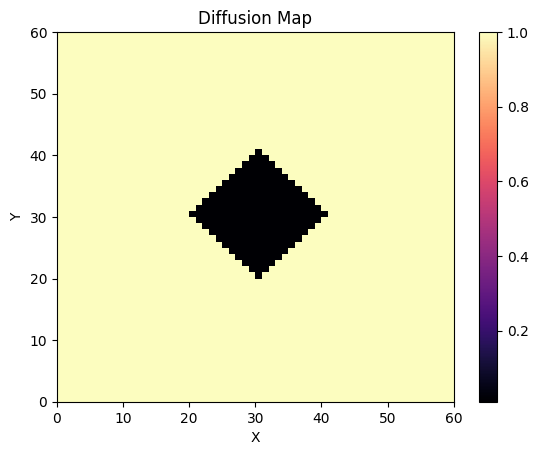

N = 120


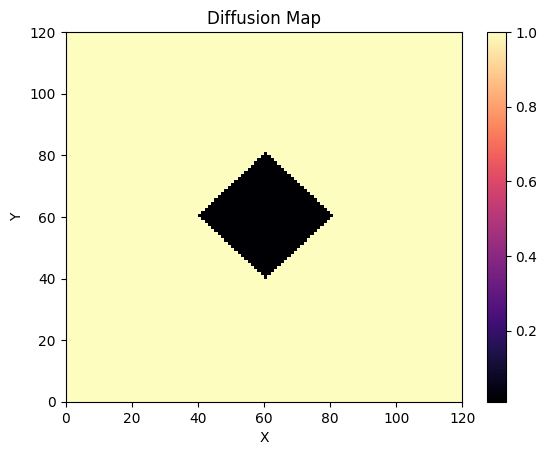

N = 240


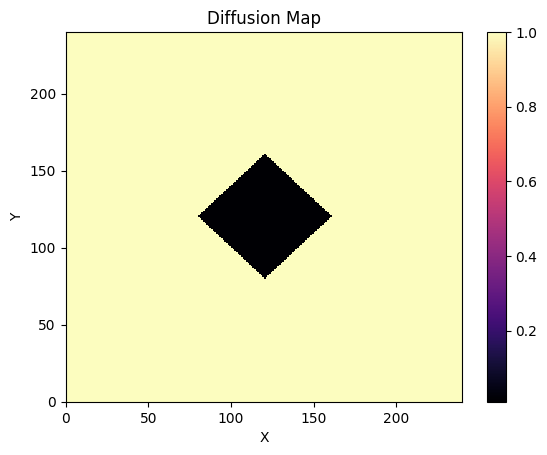

N = 480


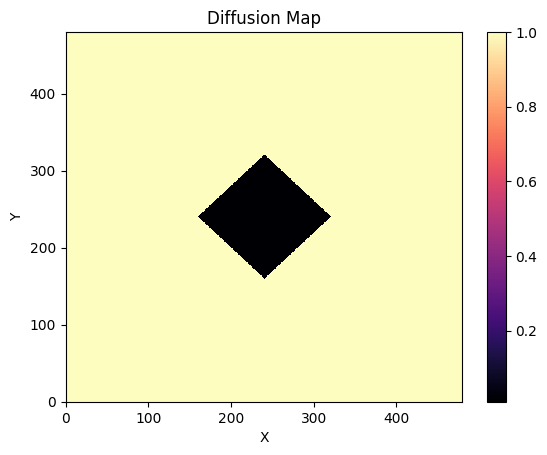

N = 960


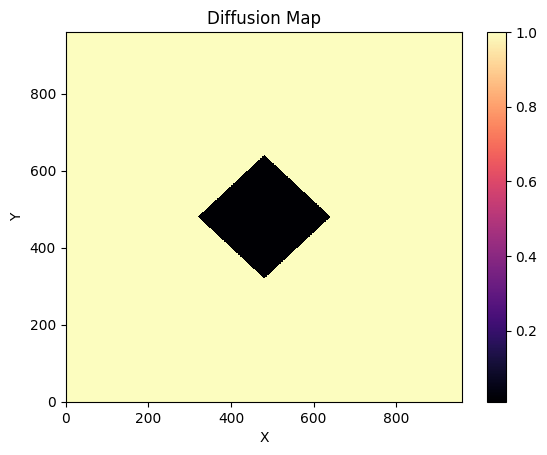

In [11]:
for n in N:
        print(f'N = {n}')

        diff_mx = create_diff_mx(n)
        plot_diffusion_map(diff_mx)

N = 60


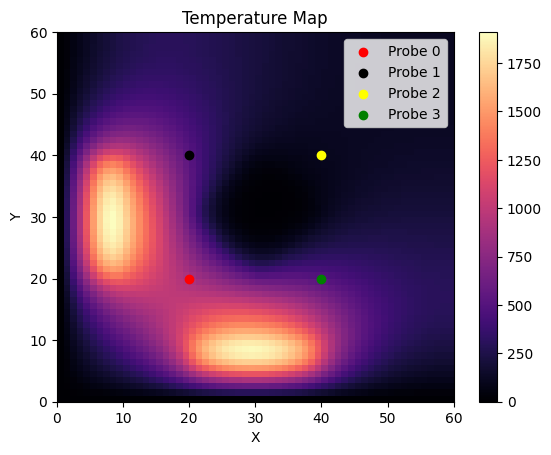

N = 120


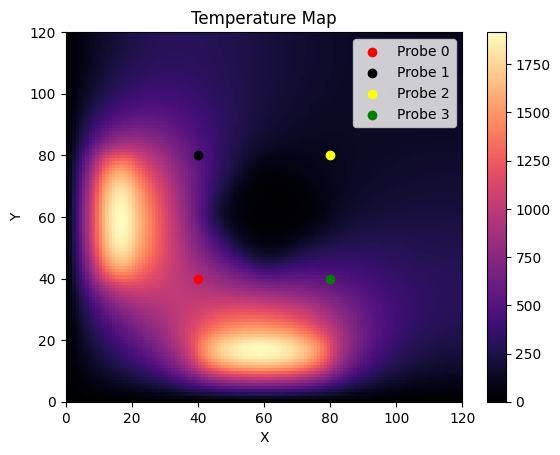

N = 240


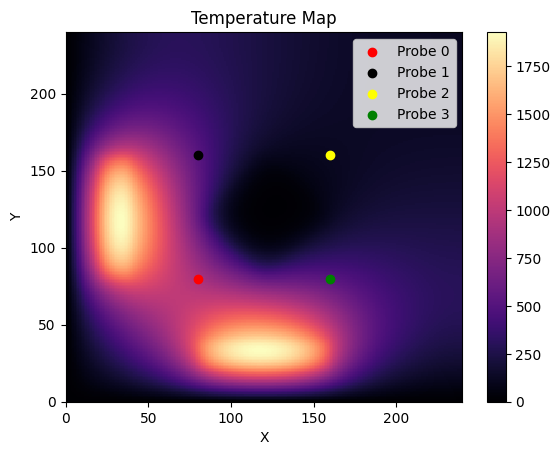

N = 480


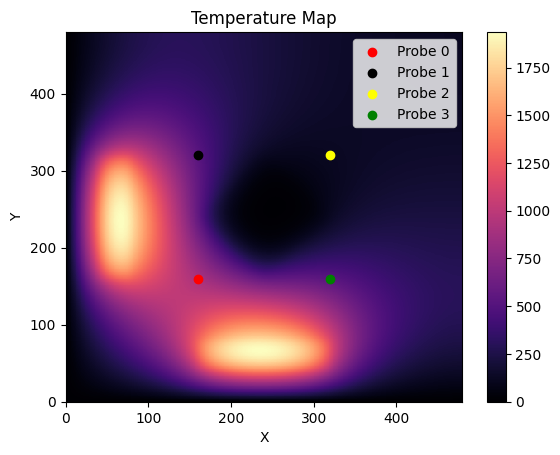

N = 960


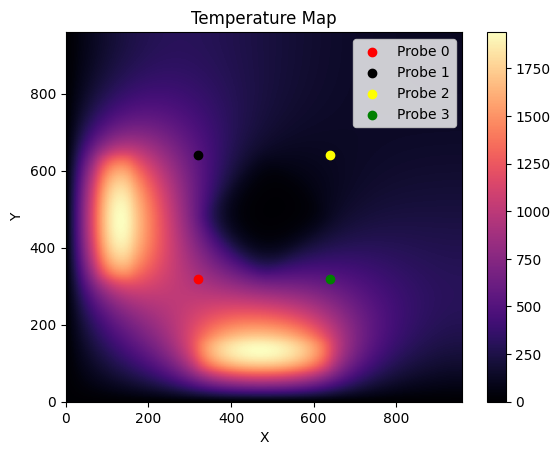

In [8]:
for n in N:
    print(f'N = {n}')
    T = np.load(f'T{n}.npy')
    prob_cord = np.load(f'C{n}.npy')
    plot_temperature_map(T, prob_cord)

N = 60
Периоды пробы 0 - []
Периоды пробы 1 - []
Периоды пробы 2 - []
Периоды пробы 3 - []


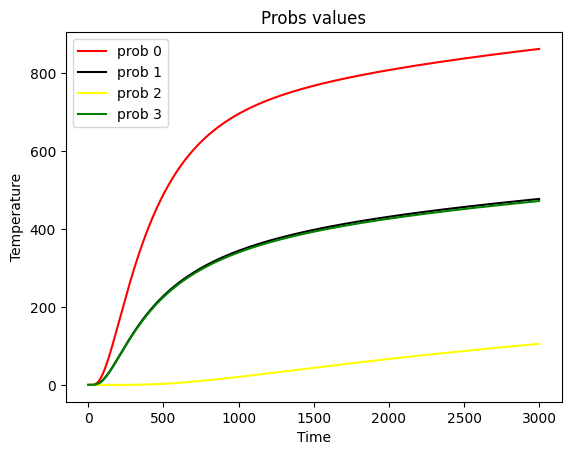

N = 120
Периоды пробы 0 - []
Периоды пробы 1 - []
Периоды пробы 2 - []
Периоды пробы 3 - []


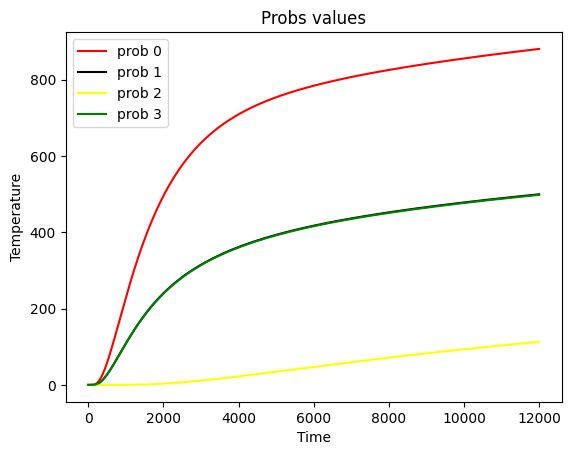

N = 240
Периоды пробы 0 - []
Периоды пробы 1 - []
Периоды пробы 2 - []
Периоды пробы 3 - []


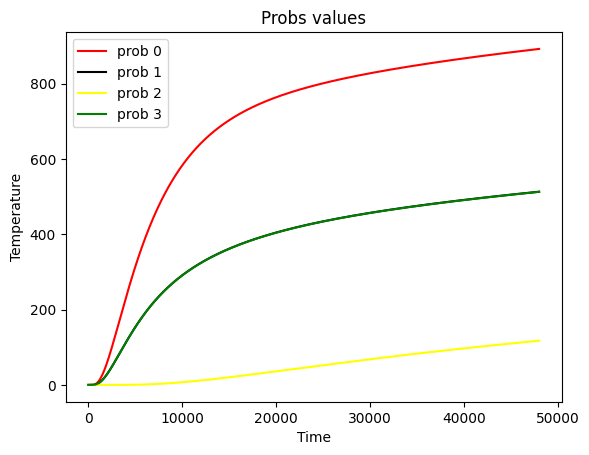

N = 480
Периоды пробы 0 - [0.4000041667100699, 0.4000125003906372, 0.4000250015625976, 0.4000375035159546, 0.40005417400272947, 0.4000666777796299, 0.40007501406513724, 0.40008751914481294, 0.4001000250062515, 0.40011253164952637, 0.4001208698460993, 0.4001375472818781, 0.4001458865211275, 0.40016256604245476, 0.40017924695436496, 0.400187587931843, 0.400200100050025, 0.4002084418968212, 0.40022095531908236, 0.40022929803533275, 0.40023764109940274, 0.4002459845113142, 0.40025850028143173, 0.4002710168343149, 0.4002793616378097, 0.40028770678925474, 0.4003002251688766, 0.4003085711902925, 0.4003169175597348, 0.40032526427722526, 0.4003336113427856, 0.40034195875643774, 0.40035448052963557, 0.40036700308616224, 0.4003753518923991, 0.4003878757546373, 0.40040457545645075, 0.4004212765513717, 0.4004338032868941, 0.4004421548793459, 0.40045468292123343, 0.40046303538466355, 0.40047556473312057, 0.4004839180676651, 0.4004922717506935, 0.40050480292869134, 0.4005131574830251, 0.4005256899680

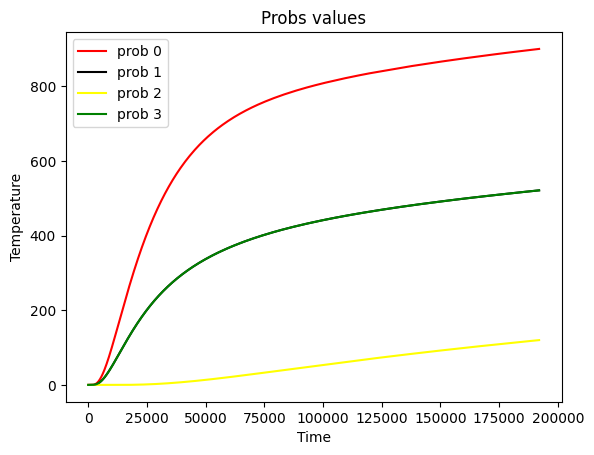

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



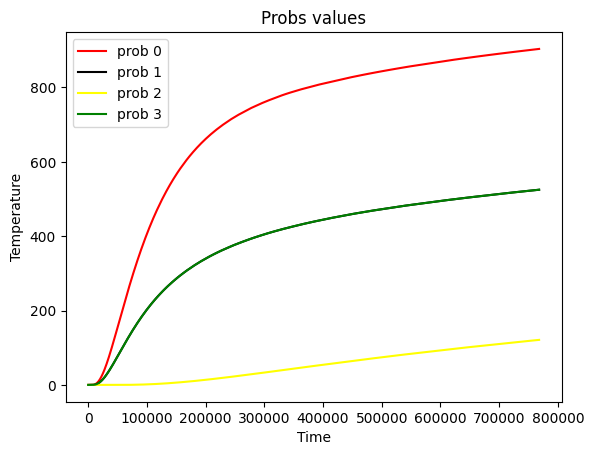

In [9]:
for n in N:
    print(f'N = {n}')
    prob = np.load('Prob' + str(n) + '.npy')
    plot_probe_values(prob)